# Linking observations of blowing snow to sublimation at Kettle Ponds

Author: Daniel Hogan
Created: April 29, 2024

This notebook will start to address three main questions (with sub-focuses discussed below):
1) How do observations of blowing snow relate to wind speeds at Kettle Ponds? Is there a stronger relationship between at different heights?
2) How does wind speed and blowing snow flux relate to sublimation over the winter period?
3) How sensitive are blowing snow sublimation estimates to the time step used to calculate them? 

Additionally, I want to go into plotting wind speed, temperature sublimation rate, humidity, and blowing snow. 

### Imports


In [1]:
# general
import os
import glob
import datetime as dt
import json
import time
# data 
import xarray as xr 
from sublimpy import utils, variables, tidy, turbulence
import numpy as np
import pandas as pd
from act import discovery, plotting
# plotting
import matplotlib.pyplot as plt
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
# helper tools
from scripts.get_sail_data import get_sail_data
from scripts.helper_funcs import create_windrose_df, mean_sounding, simple_sounding
import scripts.helper_funcs as hf
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

nctoolkit is using Climate Data Operators version 2.3.0


# Pull in SOS data

In [2]:
sos_ds_5min = xr.open_dataset('../../01_data/processed_data/sos_ds_5min_storage.nc')
sos_ds_1H = xr.open_dataset('../../01_data/processed_data/sos_ds_1H_storage.nc')
sos_ds_3H = xr.open_dataset('../../01_data/processed_data/sos_ds_3H_storage.nc')
sos_ds_6H = xr.open_dataset('../../01_data/processed_data/sos_ds_6H_storage.nc')
sos_ds_12H = xr.open_dataset('../../01_data/processed_data/sos_ds_12H_storage.nc')
sos_ds_1D = xr.open_dataset('../../01_data/processed_data/sos_ds_1day_storage.nc')

In [3]:
# filter all to dates between December 1 and April 1
sos_ds_5min = sos_ds_5min.sel(time=slice('2022-12-01', '2023-03-31'))
sos_ds_1H = sos_ds_1H.sel(time=slice('2022-12-01', '2023-03-31'))
sos_ds_3H = sos_ds_3H.sel(time=slice('2022-12-01', '2023-03-31'))
sos_ds_6H = sos_ds_6H.sel(time=slice('2022-12-01', '2023-03-31'))
sos_ds_12H = sos_ds_12H.sel(time=slice('2022-12-01', '2023-03-31'))
sos_ds_1D = sos_ds_1D.sel(time=slice('2022-12-01', '2023-03-31'))

In [4]:
sos_5min_h2o_flux_ds = sos_ds_5min[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]+[variable for variable in hf.COUNT_VARIABLES]+hf.SNOW_FLUX+hf.WIND_VARIABLES+hf.TEMPERATURE_VARIABLES]
sos_1H_h2o_flux_ds = sos_ds_1H[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]+[variable for variable in hf.COUNT_VARIABLES]+hf.SNOW_FLUX+hf.WIND_VARIABLES+hf.TEMPERATURE_VARIABLES]
sos_3H_h2o_flux_ds = sos_ds_3H[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]+[variable for variable in hf.COUNT_VARIABLES]+hf.SNOW_FLUX+hf.WIND_VARIABLES+hf.TEMPERATURE_VARIABLES]
sos_6H_h2o_flux_ds = sos_ds_6H[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]+[variable for variable in hf.COUNT_VARIABLES]+hf.SNOW_FLUX+hf.WIND_VARIABLES+hf.TEMPERATURE_VARIABLES]
sos_12H_h2o_flux_ds = sos_ds_12H[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]+[variable for variable in hf.COUNT_VARIABLES]+hf.SNOW_FLUX+hf.WIND_VARIABLES+hf.TEMPERATURE_VARIABLES]
sos_1D_h2o_flux_ds = sos_ds_1D[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]+[variable for variable in hf.COUNT_VARIABLES]+hf.SNOW_FLUX+hf.WIND_VARIABLES+hf.TEMPERATURE_VARIABLES]

# adjust wdir
def adjust_wdir(ds):
    new_df = ds.to_dataframe()
    new_ds = hf.adjust_wdir(new_df).to_xarray()
    ## Copy attributes from the original dataset
    new_ds.attrs = ds.attrs
    for var in new_ds:
        new_ds[var].attrs = ds[var].attrs
    return new_ds

sos_5min_h2o_flux_ds = adjust_wdir(sos_5min_h2o_flux_ds)
sos_1H_h2o_flux_ds = adjust_wdir(sos_1H_h2o_flux_ds)
sos_3H_h2o_flux_ds = adjust_wdir(sos_3H_h2o_flux_ds)
sos_6H_h2o_flux_ds = adjust_wdir(sos_6H_h2o_flux_ds)
sos_12H_h2o_flux_ds = adjust_wdir(sos_12H_h2o_flux_ds)


In [15]:
def replace_avg_wind_with_max_wind(ds, ds_og, resample_time):
    ## Copy attributes from the original dataset
    new_ds = ds.copy()
    new_ds[[variable for variable in hf.WIND_VARIABLES if 'spd' in variable]] = ds_og[[variable for variable in hf.WIND_VARIABLES if 'spd' in variable]].to_dataframe().resample(resample_time).max().to_xarray()

    ## Copy attributes from the original dataset
    new_ds.attrs = ds.attrs
    for var in new_ds:
        new_ds[var].attrs = ds[var].attrs
    return new_ds

sos_1H_max_wspd_ds = adjust_wdir(replace_avg_wind_with_max_wind(sos_1H_h2o_flux_ds, sos_ds_5min, '1H'))
sos_3H_max_wspd_ds = adjust_wdir(replace_avg_wind_with_max_wind(sos_3H_h2o_flux_ds, sos_1H_h2o_flux_ds, '3H'))
sos_6H_max_wspd_ds = adjust_wdir(replace_avg_wind_with_max_wind(sos_6H_h2o_flux_ds, sos_1H_h2o_flux_ds, '6H'))
sos_12H_max_wspd_ds = adjust_wdir(replace_avg_wind_with_max_wind(sos_12H_h2o_flux_ds, sos_1H_h2o_flux_ds, '12H'))
sos_1D_max_wspd_ds = adjust_wdir(replace_avg_wind_with_max_wind(sos_1D_h2o_flux_ds, sos_1H_h2o_flux_ds, '1D'))

sos_1H_max_wspd_ds.to_netcdf('../../01_data/processed_data/sos_ds_1H_max_wspd_storage.nc')

In [6]:
# calculate the 1 hour sublimation rate
rho_w = 1000
g2kg = 1/1000
# seconds in timestep
s_in_hour = 3600
s_in_3hours = 3 * s_in_hour
s_in_12hours = 12 * s_in_hour
s_in_day = 24 * s_in_hour

In [7]:
# build a function to do this:
def delineate_bs_conditions(ds, 
                            wspd_threshold=4, 
                            bs_threshold=0.001, 
                            timestep=1, 
                            height=3,
                            output_type='bs'):
    bsf_timestep = (ds['SF_avg_1m_ue'] + ds['SF_avg_2m_ue'])/timestep
    bsf_timestep.name = 'BSF_timestep'
    # create a blowing snow mask, set value to 1 when greater than 0.001 and 0 otherwise
    bsf_mask_timestep = bsf_timestep.where(bsf_timestep > bs_threshold, 0)
    bsf_mask_timestep.name = 'BSF_mask_timestep'

    # calculate the sublimation rate for 1 hour
    sublimation_timestep = (ds[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]] * 1/rho_w * 1000 * g2kg * s_in_hour*timestep).to_dataframe()
    # get the total number of hours in the dataset
    total_hours = sublimation_timestep.shape[0]
    # get the sum total over winter
    total_sublimation = sublimation_timestep.sum(axis=0)

    ######## Explicit Blowing Snow Conditions from Observations ########
    # get the sum total over winter for blowing snow
    total_bs_sublimation = sublimation_timestep.loc[bsf_mask_timestep[bsf_mask_timestep>0].time.values].sum(axis=0)
    # get the total number of hours in the dataset for blowing snow
    total_bs_hours = sublimation_timestep.loc[bsf_mask_timestep[bsf_mask_timestep>0].time.values].shape[0]
    # get the sum total over winter for non-blowing snow
    total_nbs_sublimation = sublimation_timestep.loc[bsf_mask_timestep[bsf_mask_timestep==0].time.values].sum(axis=0)
    # get the total number of hours in the dataset for non-blowing snow
    total_nbs_hours = sublimation_timestep.loc[bsf_mask_timestep[bsf_mask_timestep==0].time.values].shape[0]


    ####### Blowing Snow from Wind Speed and Blowing Snow Threshold ########
    wsp_timestep = ds[[variable for variable in hf.WIND_VARIABLES if 'spd' in variable]]
    # filter to times when the wind speed is greater than the threshold
    wsp_mask_timestep = bsf_mask_timestep.where(wsp_timestep > wspd_threshold, 0)
    # filter to times with blowing snow, take the mean at 10 meters!!!!!!
    wsp_bs_mask_timestep = wsp_mask_timestep[[variable for variable in wsp_mask_timestep if '10m' in variable]].to_dataframe().mean(axis=1)
    # windy + blowing snow sublimation
    total_bs_wsp_sublimation = sublimation_timestep.loc[wsp_bs_mask_timestep[wsp_bs_mask_timestep>0].index].sum(axis=0)
    # get hours of windy + blowing snow
    total_bs_wsp_hours = sublimation_timestep.loc[wsp_bs_mask_timestep[wsp_bs_mask_timestep>0].index].shape[0]
    # non-windy, non-blowing snow sublimation
    total_nbs_wsp_sublimation = sublimation_timestep.loc[wsp_bs_mask_timestep[wsp_bs_mask_timestep==0].index].sum(axis=0)
    # get hours of non-windy, non-blowing snow
    total_nbs_wsp_hours = sublimation_timestep.loc[wsp_bs_mask_timestep[wsp_bs_mask_timestep==0].index].shape[0]

    ####### Blowing Snow from Wind Speed Threshold Only ########
    wsp_timestep = ds[[variable for variable in hf.WIND_VARIABLES if 'spd' in variable]]
    # filter to times when the wind speed is greater than the threshold
    wsp_mask_timestep = wsp_timestep.where(wsp_timestep > wspd_threshold, 0)
    # get the average at 10 meters
    wsp_mask_timestep = wsp_mask_timestep[[var for var in wsp_mask_timestep.data_vars if '10m' in var]].to_dataframe().mean(axis=1)
    wsp_mask_timestep = wsp_mask_timestep.where(wsp_mask_timestep > wspd_threshold, 0)
    # windy snow sublimation
    total_wsp_only_sublimation = sublimation_timestep.loc[sublimation_timestep[wsp_mask_timestep>0].index].sum(axis=0)
    # get hours of windy snow
    total_wsp_only_hours = sublimation_timestep.loc[sublimation_timestep[wsp_mask_timestep>0].index].shape[0]
    # non-windy, non-blowing snow sublimation
    total_nbs_wsp_only_sublimation = sublimation_timestep.loc[sublimation_timestep[wsp_mask_timestep==0].index].sum(axis=0)
    # get hours of non-windy, non-blowing snow
    total_nbs_wsp_only_hours = sublimation_timestep.loc[sublimation_timestep[wsp_mask_timestep==0].index].shape[0]

    data_dict = {'blowing_snow_obs':[total_bs_sublimation, total_nbs_sublimation, total_bs_hours, total_nbs_hours],
     'blowing_snow_and_wsp_obs':[total_bs_wsp_sublimation,total_nbs_wsp_sublimation,total_bs_wsp_hours,total_nbs_wsp_hours],
     'wsp_only_obs':[total_wsp_only_sublimation,total_nbs_wsp_only_sublimation,total_wsp_only_hours,total_nbs_wsp_only_hours]}

    if output_type == 'bs':
        output = 'blowing_snow_obs'
    elif output_type == 'bs+wsp':
        output = 'blowing_snow_and_wsp_obs'
    elif output_type == 'wsp':
        output = 'wsp_only_obs'
    # build a stacked bar chart showing the total sublimation for blowing and non-blowing snow conditions
    sublimation_timestep_stacked = pd.DataFrame(
        {'total_bs_sublimation': (data_dict[output][0]/total_sublimation)*100, 
        'total_nbs_sublimation': (data_dict[output][1]/total_sublimation)*100},
        # 'total_sublimation': total_sublimation},
        )
    # get the mean at 10 meters
    sublimation_timestep_stacked = sublimation_timestep_stacked[sublimation_timestep_stacked.index.str.contains(f'{height}m_')].mean().to_frame().T
    # rename index values to 'value'
    sublimation_timestep_stacked.index = [f'value_{timestep}H']

    # Total sublimation time stacked
    bs_time_timestep_stacked = pd.DataFrame(
        {'total_bs_sublimation': (data_dict[output][2]/total_hours)*100, 
        'total_nbs_sublimation': (data_dict[output][3]/total_hours)*100}, index=[f'time_{timestep}H'])
    # merge the two dataframes
    blowing_snow_timestep = pd.concat([sublimation_timestep_stacked, bs_time_timestep_stacked], axis=0)
    return blowing_snow_timestep

In [8]:
output_type = 'wsp'
df = pd.concat([delineate_bs_conditions( sos_1H_max_wspd_ds, bs_threshold=0.001, timestep=1,  wspd_threshold=5, height=3, output_type=output_type),
                delineate_bs_conditions( sos_3H_max_wspd_ds, bs_threshold=0.001, timestep=3,  wspd_threshold=5, height=3, output_type=output_type),
                delineate_bs_conditions( sos_6H_max_wspd_ds, bs_threshold=0.001, timestep=6,  wspd_threshold=5, height=3, output_type=output_type),
                delineate_bs_conditions(sos_12H_max_wspd_ds, bs_threshold=0.001, timestep=12, wspd_threshold=5, height=3, output_type=output_type),
                delineate_bs_conditions( sos_1D_max_wspd_ds, bs_threshold=0.001, timestep=24, wspd_threshold=5, height=3, output_type=output_type)])

In [9]:

if output_type == 'bs':
    val_1 = 'Blowing Snow'
    val_2 = 'Non-Blowing Snow'
elif output_type == 'bs+wsp':
    val_1 = 'Avg Winds > Threshold + Blowing Snow'
    val_2 = 'Avg Winds < Thresholdy + Non-Blowing Snow'
elif output_type == 'wsp':
    val_1 = 'Avg Winds > Threshold'
    val_2 = 'Avg Winds < Threshold'

idx = pd.Series([index.split('_')[1] for index in df.index]).unique()
df_new = pd.concat(
    [
        pd.DataFrame(
            df[df.index.str.contains('value')].values,
            index=idx,
            columns=[val_1, val_2]
        ),
        pd.DataFrame(
            df[df.index.str.contains('time')].values,
            index=idx,
            columns=[val_1, val_2]
        ),
    ],
    axis=1,
    keys=["Sublimation", "Hours"]
)
df_new

Sublimation                                       Hours  \
    Avg Winds > Threshold Avg Winds < Threshold Avg Winds > Threshold   
1H              81.829117             18.170883             28.994490   
3H              57.634078             42.365922             21.694215   
6H              66.206134             33.793866             28.512397   
12H             73.927736             26.072264             40.495868   
24H             80.472695             19.527305             56.198347   

                           
    Avg Winds < Threshold  
1H              71.005510  
3H              78.305785  
6H              71.487603  
12H             59.504132  
24H             43.801653

In [10]:
# Create a figure with the right layout
fig = go.Figure(
    layout=go.Layout(
        height=600,
        width=1000,
        barmode="relative",
        yaxis_showticklabels=True,
        yaxis_showgrid=True,
        yaxis_range=[0, 110],
        yaxis_title="Percentage of Total (%)",
        xaxis_title="Averaging Period (Hours)",
       # Secondary y-axis overlayed on the primary one and not visible
        yaxis2=go.layout.YAxis(
            visible=False,
            matches="y",
            overlaying="y",
            anchor="x",
        ),
        font=dict(size=16),
        legend_x=0,
        legend_y=1.3,
        legend_orientation="h",
        hovermode="x",
        margin=dict(b=0,t=10,l=0,r=10)
    )
)

# Define some colors for the product, revenue pairs
colors = {
    "Sublimation": {
        val_1: "#F28F1D",
        val_2: "#FADD75",
    },
    "Hours": {
        val_1: "#2B6045",
        val_2: "#9ED4B9",
    }
}

# Add the traces
for i, t in enumerate(colors):
    for j, col in enumerate(df_new[t].columns):
        if (df_new[t][col] == 0).all():
            continue
        fig.add_bar(
            x=df_new.index,
            y=df_new[t][col],
            # Set the right yaxis depending on the selected product (from enumerate)
            yaxis=f"y{i + 1}",
            # Offset the bar trace, offset needs to match the width
            # The values here are in milliseconds, 1billion ms is ~1/3 month
            offsetgroup=str(i),
            offset=(i - 1) * 0.25,
            width=0.25,
            legendgroup=t,
            legendgrouptitle_text=t,
            name=col,
            marker_color=colors[t][col],
            marker_line=dict(width=2, color="#333"),
            hovertemplate="%{y}<extra></extra>"
        )

fig.show()
fig.write_image("../../04_products/figures/sandbox/blowing_snow_sublimation.png")

In [14]:
max_val = sos_1H_max_wspd_ds['w_h2o__3m_uw'].mean()+(sos_1H_max_wspd_ds['w_h2o__3m_uw'].std()*3)
min_val = sos_1H_max_wspd_ds['w_h2o__3m_uw'].mean()-(sos_1H_max_wspd_ds['w_h2o__3m_uw'].std()*3)
sos_1H_max_wspd_ds['bsf'] = np.log(sos_1H_max_wspd_ds['SF_avg_1m_ue']+sos_1H_max_wspd_ds['SF_avg_2m_ue']).where(sos_1H_max_wspd_ds['SF_avg_1m_ue']+sos_1H_max_wspd_ds['SF_avg_2m_ue']>0)
fig = px.scatter(sos_1H_max_wspd_ds.where((sos_1H_max_wspd_ds['w_h2o__3m_uw']<max_val) &
                                          (sos_1H_max_wspd_ds['w_h2o__3m_uw']>min_val) & 
                                            (sos_1H_max_wspd_ds['spd_10m_ue']>=4)
                                          ),
                 x='spd_10m_ue',
                y='bsf',
                trendline='ols',)
# update the layout
fig.update_layout(
    xaxis_title="Max 1H Wind Speed (m/s)",
    yaxis_title="log(Hourly Mean Blowing Snow Flux) (g/m^2/s)",
    # log scale on y-axis
    # yaxis_type="log",
    font=dict(size=16),
    height=600,
    width=600
)

divide by zero encountered in log


We can see here there is a sensitivity between blowing snow flux and sublimation. Now let's see if we can deduce a relationship with windspeed as well.

In [67]:
ds = sos_1H_h2o_flux_ds
sublimation_1H = (ds[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]] * 1/rho_w * 1000 * g2kg * s_in_hour).to_dataframe()
# get the mean at the 3 meter height
sublimation_1H = sublimation_1H[[var for var in sublimation_1H if 'w_h2o__10m' in var]].mean(axis=1).to_frame()
sublimation_1H.columns = ['sublimation_1H']
# wind speed
wind_speed_1H = sos_1H_h2o_flux_ds['spd_10m_ue']
wind_speed_1H.name = 'wind_speed_1H'
# wind direction
wind_direction_1H = sos_1H_h2o_flux_ds['dir_10m_ue']
wind_direction_1H.name = 'wind_direction_1H'
# temperature at 3m on c
temperature_1H = sos_1H_h2o_flux_ds['T_3m_c']
temperature_1H.name = 'temperature_1H'
# blowing snow flux
bsf_timestep = (ds['SF_avg_1m_ue'] + ds['SF_avg_2m_ue'])

# add to the sublimation rate
sublimation_1H['wind_speed_1H'] = wind_speed_1H.values
sublimation_1H['wind_direction_1H'] = wind_direction_1H.values
sublimation_1H['temperature_1H'] = temperature_1H.values
sublimation_1H['bsf'] = bsf_timestep.values

In [68]:
ds = sos_3H_h2o_flux_ds
sublimation_3H = (ds[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]] * 1/rho_w * 1000 * g2kg * s_in_3hours).to_dataframe()
# get the mean at the 3 meter height
sublimation_3H = sublimation_3H[[var for var in sublimation_3H if 'w_h2o__10m' in var]].mean(axis=1).to_frame()
sublimation_3H.columns = ['sublimation_3H']
# wind speed
wind_speed_3H= sos_3H_h2o_flux_ds['spd_10m_ue']
wind_speed_3H.name = 'wind_speed_3H'
# wind direction
wind_direction_3H= sos_3H_h2o_flux_ds['dir_10m_ue']
wind_direction_3H.name = 'wind_direction_3H'
# temperature at 3m on c
temperature_3H = sos_3H_h2o_flux_ds['T_3m_c']
temperature_3H.name = 'temperature_3H'
# blowing snow flux
bsf_timestep = (ds['SF_avg_1m_ue'] + ds['SF_avg_2m_ue'])

# add to the sublimation rate
sublimation_3H['wind_speed_3H'] = wind_speed_3H.values
sublimation_3H['wind_direction_3H'] = wind_direction_3H.values
sublimation_3H['temperature_3H'] = temperature_3H.values
sublimation_3H['bsf'] = bsf_timestep.values


In [69]:
ds = sos_6H_h2o_flux_ds
sublimation_6H = (ds[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]] * 1/rho_w * 1000 * g2kg * s_in_3hours*2).to_dataframe()
# get the mean at the 3 meter height
sublimation_6H = sublimation_6H[[var for var in sublimation_6H if 'w_h2o__10m' in var]].mean(axis=1).to_frame()
sublimation_6H.columns = ['sublimation_6H']
# wind speed
wind_speed_6H= sos_6H_h2o_flux_ds['spd_10m_ue']
wind_speed_6H.name = 'wind_speed_6H'
# wind direction
wind_direction_6H= sos_6H_h2o_flux_ds['dir_10m_ue']
wind_direction_6H.name = 'wind_direction_6H'
# temperature at 3m on c
temperature_6H = sos_6H_h2o_flux_ds['T_3m_c']
temperature_6H.name = 'temperature_6H'
# blowing snow flux
bsf_timestep = (ds['SF_avg_1m_ue'] + ds['SF_avg_2m_ue'])

# add to the sublimation rate
sublimation_6H['wind_speed_6H'] = wind_speed_6H.values
sublimation_6H['wind_direction_6H'] = wind_direction_6H.values
sublimation_6H['temperature_6H'] = temperature_6H.values
sublimation_6H['bsf'] = bsf_timestep.values


In [70]:
ds = sos_12H_h2o_flux_ds
sublimation_12H = (ds[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]] * 1/rho_w * 1000 * g2kg * s_in_12hours).to_dataframe()
# get the mean at the 3 meter height
sublimation_12H = sublimation_12H[[var for var in sublimation_12H if 'w_h2o__10m' in var]].mean(axis=1).to_frame()
sublimation_12H.columns = ['sublimation_12H']
# wind speed
wind_speed_12H= sos_12H_h2o_flux_ds['spd_10m_ue']
wind_speed_12H.name = 'wind_speed_12H'
# wind direction
wind_direction_12H= sos_12H_h2o_flux_ds['dir_10m_ue']
wind_direction_12H.name = 'wind_direction_12H'
# temperature at 3m on c
temperature_12H = sos_12H_h2o_flux_ds['T_3m_c']
temperature_12H.name = 'temperature_12H'
# blowing snow flux
bsf_timestep = (ds['SF_avg_1m_ue'] + ds['SF_avg_2m_ue'])

# add to the sublimation rate
sublimation_12H['wind_speed_12H'] = wind_speed_12H.values
sublimation_12H['wind_direction_12H'] = wind_direction_12H.values
sublimation_12H['temperature_12H'] = temperature_12H.values
sublimation_12H['bsf'] = bsf_timestep.values


In [71]:
ds = sos_1D_h2o_flux_ds
sublimation_1D = (ds[[variable for variable in hf.TURBULENCE_VARIABLES if 'w_h2o' in variable]] * 1/rho_w * 1000 * g2kg * s_in_day).to_dataframe()
# get the mean at the 3 meter height
sublimation_1D = sublimation_1D[[var for var in sublimation_1D if 'w_h2o__10m' in var]].mean(axis=1).to_frame()
sublimation_1D.columns = ['sublimation_24H']
# wind speed
wind_speed_1D= sos_1D_h2o_flux_ds['spd_10m_ue']
wind_speed_1D.name = 'wind_speed_24H'
# wind direction
wind_direction_1D= sos_1D_h2o_flux_ds['dir_10m_ue']
wind_direction_1D.name = 'wind_direction_24H'
# temperature at 3m on c
temperature_1D = sos_1D_h2o_flux_ds['T_3m_c']
temperature_1D.name = 'temperature_23H'
# blowing snow flux
bsf_timestep = (ds['SF_avg_1m_ue'] + ds['SF_avg_2m_ue'])

# add to the sublimation rate
sublimation_1D['wind_speed_24H'] = wind_speed_1D.values
sublimation_1D['wind_direction_24H'] = wind_direction_1D.values
sublimation_1D['temperature_24H'] = temperature_1D.values
sublimation_1D['bsf'] = bsf_timestep.values


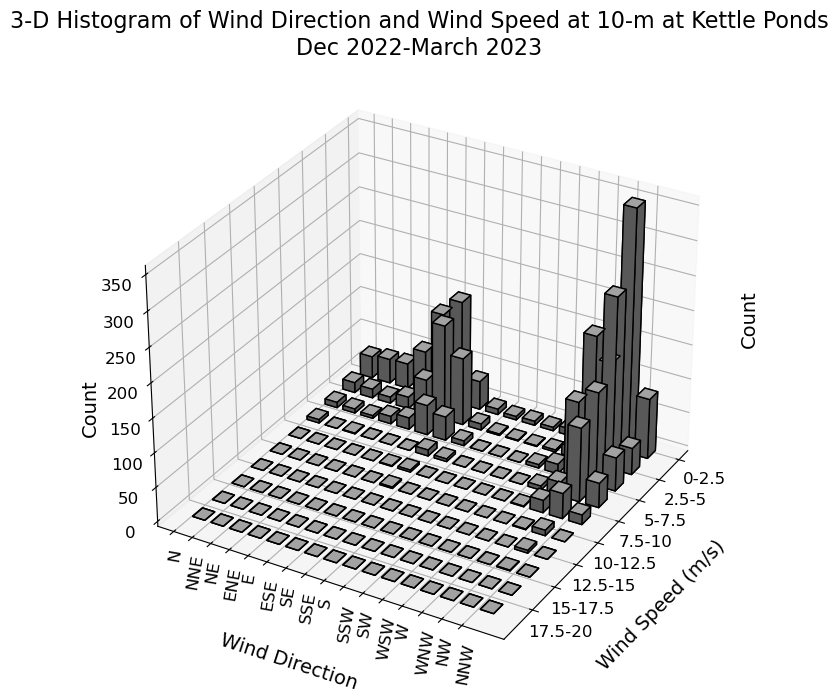

In [72]:
df_to_use = sublimation_1H.sel(time=slice('2023--01', '2023-03-31')
timestep=1

df_test = df_to_use[[f'sublimation_{timestep}H', f'wind_speed_{timestep}H', f'wind_direction_{timestep}H', f'temperature_{timestep}H']]
# create a 3d histogram in matplotlib to show the relationship between wind speed, wind direction, and total sublimation
# To generate some test data
xAmplitudes = df_test[f'wind_speed_{timestep}H']#your data here
yAmplitudes = df_test[f'wind_direction_{timestep}H']#your other data here


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
hist, xedges, yedges = np.histogram2d(xAmplitudes, yAmplitudes, bins=[10,16], range=[[0, 20], [0, 360]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1]+6.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = 1*np.ones_like(zpos)
dy = 15 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='max', color='lightgrey', ec='black')
# rotate the plot
ax.view_init(30, 30,0)
# replace y-axis labels with cardinal wind direction lables
ax.set_yticks([0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5])
ax.set_yticklabels(['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'], rotation=80, fontsize=12, ha='left')

ax.set_xticks([0,2.5,5,7.5,10,12.5,15,17.5])
ax.set_xticklabels(['0-2.5', '2.5-5', '5-7.5', '7.5-10', '10-12.5', '12.5-15', '15-17.5', '17.5-20'], rotation=0, fontsize=12, ha='center', va='bottom')
ax.tick_params(axis='x', pad=10)
ax.tick_params(axis='y', pad=0)
# increase tick label size on zaxis
ax.tick_params(axis='z', labelsize=12)
# ax.set_zlim(0,40)
# show z-axis on the right
ax.zaxis.set_rotate_label(False)
ax.zaxis.set_label_position('both')

ax.set_zlabel('Count', rotation=90, fontsize=14)
ax.set_xlabel('Wind Speed (m/s)', fontsize=14)
ax.set_ylabel('Wind Direction', fontsize=14)
# pad the x-axis label
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.set_title('3-D Histogram of Wind Direction and Wind Speed at 10-m at Kettle Ponds\nDec 2022-March 2023', fontsize=16)

plt.show()

### Make Heatmaps of Sublimation with Wind Speed and Direction

In [73]:
# wind speed bins
wspd_bins = [0, 2, 4, 6, 8, 10,]
# wind direction bins
wdir_bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]

# wspd cut and sum sublimation for each bin
wsp_assignment = pd.cut(df_test[f'wind_speed_{timestep}H'], bins=wspd_bins, labels=wspd_bins[:-1])
wsp_assignment.name = 'wsp_assignment'
# wdir cut and sum sublimation for each bin
wdir_assignment = pd.cut(df_test[f'wind_direction_{timestep}H'], bins=wdir_bins, labels=wdir_bins[:-1])
wdir_assignment.name = 'wdir_assignment'

# combine the two assignments and the sublimation
df_test['wsp_assignment'] = wsp_assignment.values
df_test['wdir_assignment'] = wdir_assignment.values

# groupby the wspd and wdir assignments and get the sum of w_h2o__3m_uw
grouped = df_test.groupby(['wsp_assignment', 'wdir_assignment']).sum()[f'sublimation_{timestep}H']
# unstack and put into a dataframe
grouped =(grouped.unstack())

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [74]:
# plot grouped as a heatmap
fig = go.Figure()
fig.add_trace(go.Heatmap(z=grouped.values, 
                         x=grouped.columns, 
                         y=grouped.index,

                        colorbar={'title':'Sublimation<br>(mm)'},
                        colorscale='RdBu_r',
                        # min and max color values
                        zmin=-2,
                        zmax=2,
                        xgap=1,
                        ygap=1,
                         ))
# add grid
fig.update_layout(height=400, 
                  width=600,
                  xaxis_title='Wind Direction',
                  yaxis_title='Wind Speed',
                  title=f'Wind Speed and Wind Direction Sublimation<br>Averaging time = {timestep} Hour(s)',
                  )
# change x-axis ticks to be cardinal wind directions
fig.update_xaxes(tickvals=[0, 45, 90, 135, 180, 225, 270, 315], ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
# update y-axes ticks to be wind speed bins
fig.update_yaxes(tickvals=[0, 2, 4, 6, 8, 10,], ticktext=['0-2', '2-4', '4-6', '6-8', '8-10+'])
# update legend title to legend_title='Percent of Winter Sublimation (%)'

In [263]:
# wind speed bins
wspd_bins = [0, 2, 4, 6, 8, 10,]
# wind direction bins
wdir_bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]

# wspd cut and sum sublimation for each bin
wsp_assignment = pd.cut(df_test[f'wind_speed_{timestep}H'], bins=wspd_bins, labels=wspd_bins[:-1])
wsp_assignment.name = 'wsp_assignment'
# wdir cut and sum sublimation for each bin
wdir_assignment = pd.cut(df_test[f'wind_direction_{timestep}H'], bins=wdir_bins, labels=wdir_bins[:-1])
wdir_assignment.name = 'wdir_assignment'

# combine the two assignments and the sublimation
df_test['wsp_assignment'] = wsp_assignment.values
df_test['wdir_assignment'] = wdir_assignment.values

# groupby the wspd and wdir assignments and get the sum of w_h2o__3m_uw
grouped_temperature = df_test.groupby(['wsp_assignment', 'wdir_assignment']).mean()[f'temperature_{timestep}H']
# unstack and put into a dataframe
grouped_temperature = grouped_temperature.unstack()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [266]:
# plot grouped_temperature as a heatmap
fig = go.Figure()
fig.add_trace(go.Heatmap(z=grouped_temperature.values, 
                         x=grouped_temperature.columns, 
                         y=grouped_temperature.index,

                        colorbar={'title':'Temperature<br>(&deg;C)'},
                        colorscale='RdBu_r',
                        # min and max color values
                        zmin=-12,
                        zmax=0,
                        xgap=1,
                        ygap=1,
                         ))
# add grid
fig.update_layout(height=400, 
                  width=600,
                  xaxis_title='Wind Direction',
                  yaxis_title='Wind Speed',
                  title=f'Wind Speed and Wind Direction Temperature<br>Averaging time = {timestep} Hour(s)',
                  )
# change x-axis ticks to be cardinal wind directions
fig.update_xaxes(tickvals=[0, 45, 90, 135, 180, 225, 270, 315], ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
# update y-axes ticks to be wind speed bins
fig.update_yaxes(tickvals=[0, 2, 4, 6, 8, 10,], ticktext=['0-2', '2-4', '4-6', '6-8', '8-10+',])
# update legend title to legend_title='Percent of Winter Sublimation (%)'

In [14]:

# create a scatter plot with the wind speed on the x-axis and the sublimation rate on the y-axis and the markers sized by the blowing snow flux (log scale)
fig1 = px.scatter(sublimation_1H.dropna(), 
                 x=f'wind_speed_{timestep}H', 
                 y=f'sublimation_{timestep}H', 
                 size='bsf', 
                 # color by wind direction
                 color=f'temperature_{timestep}H',
                 color_continuous_scale='RdBu_r',
                 # make edge color black
                 # provide size scale
                    size_max=50,
                 title=f'Wind Speed and Sublimation Rate <br> sized by BSF and averaged over {timestep}H')


fig1.update_traces(marker=dict(
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

df_l = sublimation_1H.sort_values('bsf')
# fill df_1 with 0 for nan values
df_l = df_l.fillna(0)

fig2 = px.scatter(
    df_l,
    x=np.zeros(6),
    y=np.array(pd.cut(df_l["bsf"], bins=np.array([0,0.0001,0.001,0.01,0.1,10,100]), right=False).unique().astype(str)),
    size=np.array([0.0001,0.001,0.01,0.1,10,100]),
    size_max=50,
    # set color to gray
)

fig2.update_traces(marker=dict(
                            color='gray',
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))



fig = go.Figure(
    data=[t for t in fig1.data] + [t.update(xaxis="x2", yaxis="y2") for t in fig2.data],
    layout=fig1.layout,
)

# now config axes appropriately
fig.update_layout(
    xaxis_domain=[0, 0.90],
    xaxis1=dict(title='Wind Speed (m/s)'),
    yaxis1=dict(title='Sublimation Rate (mm/hr)'),
    xaxis2={"domain": [0.905, 1], "matches": None, "visible": False},
    yaxis2={"title":"Blowing Snow Flux (g/m^2/s)","anchor": "free", "overlaying": "y", "side": "right", "position": 1},
    showlegend=False,
    height=600, width=1000,
    coloraxis_colorbar_title_text ='Temperature (&deg;C)'
)

# size the legend in a log scale
fig.update_layout(legend=dict(itemsizing='constant',))
# move the colorbar axis to the right, flip orientation
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", 
                                          y=-0.2, 
                                          x=-0.10, 
                                          xanchor="left", 
                                          title='Temperature (&deg;C)',
                                          orientation='h'))


NameError: name 'sublimation_1H' is not defined

In [269]:
# create a scatter plot with the wind speed on the x-axis and the sublimation rate on the y-axis and the markers sized by the blowing snow flux (log scale)
fig1 = px.scatter(sublimation_1H.dropna(), 
                 x=f'wind_speed_{timestep}H', 
                 y=f'sublimation_{timestep}H', 
                 size='bsf', 
                 # color by wind direction
                 color=f'wind_direction_{timestep}H',
                 color_continuous_scale='twilight',
                 # provide size scale
                    size_max=50,
                 title=f'Wind Speed and Sublimation Rate <br> sized by BSF and averaged over {timestep}H')

fig1.update_traces(marker=dict(
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

df_l = sublimation_1H.sort_values('bsf')
# fill df_1 with 0 for nan values
df_l = df_l.fillna(0)

fig2 = px.scatter(
    df_l,
    x=np.zeros(6),
    y=np.array(pd.cut(df_l["bsf"], bins=np.array([0,0.0001,0.001,0.01,0.1,10,100]), right=False).unique().astype(str)),
    size=np.array([0.0001,0.001,0.01,0.1,10,100]),
    size_max=50,
    # set color to gray
)

fig2.update_traces(marker=dict(
                            color='gray',
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))



fig = go.Figure(
    data=[t for t in fig1.data] + [t.update(xaxis="x2", yaxis="y2") for t in fig2.data],
    layout=fig1.layout,
)

# now config axes appropriately
fig.update_layout(
    xaxis_domain=[0, 0.90],
    xaxis1=dict(title='Wind Speed (m/s)'),
    yaxis1=dict(title='Sublimation Rate (mm/hr)'),
    xaxis2={"domain": [0.905, 1], "matches": None, "visible": False},
    yaxis2={"title":"Blowing Snow Flux (g/m^2/s)","anchor": "free", "overlaying": "y", "side": "right", "position": 1},
    showlegend=False,
    height=600, width=1000,
)

# size the legend in a log scale
fig.update_layout(legend=dict(itemsizing='constant',))
# move the colorbar axis to the right, flip orientation
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", 
                                          y=-0.2, 
                                          x=0, 
                                          xanchor="left", 
                                          title='Wind Direction (&deg;)',
                                          orientation='h'))

